In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### Modeling a glucose pulse in Saccharomyces.
Thanks to alot of work from olga we have a pytorch implementation of glycolysis. We will now build the model slightly different, with a matrix S and fluxes v, but the fluxes are defined very similarly to the pytorch project. Workflow
1. Start inspecting data. C1: For glucose_EC, we might need to interpolate. See how we can do this in diffrax.

Text(0.5, 1.0, 'Glucose pulse')

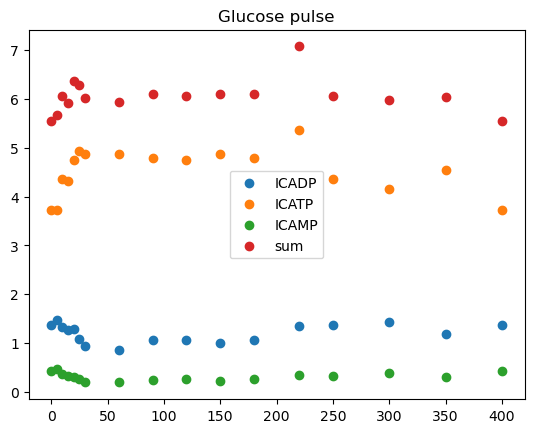

In [2]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
time_points=[int(i) for i in glycolysis_data.index.to_list()]

# plt.scatter(time_points,glycolysis_data['ECglucose'],label="ECglucose")
# plt.scatter(time_points,glycolysis_data['ICglucose'],label="ICglucose")
# plt.scatter(time_points,glycolysis_data['ICtreh'],label="ICtreh")
plt.scatter(time_points,glycolysis_data['ICADP'],label="ICADP")
plt.scatter(time_points,glycolysis_data['ICATP'],label="ICATP")
plt.scatter(time_points,glycolysis_data['ICAMP'],label="ICAMP")
plt.scatter(time_points,glycolysis_data['ICAMP']+glycolysis_data['ICADP']+glycolysis_data['ICATP'],label="sum")
# plt.scatter(glycolysis_data.index,glycolysis_data['ICF6P'],label="ICF6P")
plt.legend()
plt.title("Glucose pulse")
# plt.ylabel("Log(Concentration)")
# plt.yscale("symlog")


In [3]:
np.mean(glycolysis_data['ICAMP'])

0.3155744374809917

Text(0.5, 1.0, 'Interpolation')

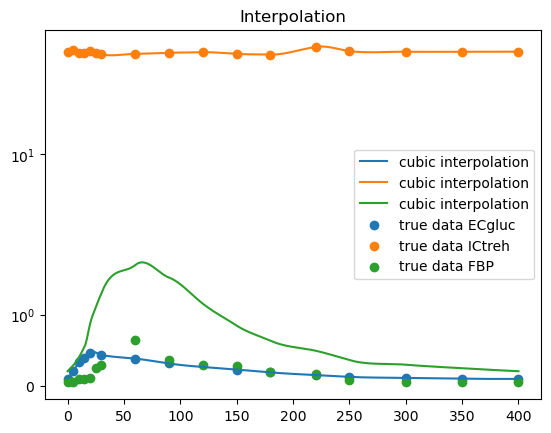

In [17]:
time_points=[int(i) for i in glycolysis_data.index.to_list()]



EC_glucose_missing=diffrax.linear_interpolation(ts=jnp.array(time_points),
                                                     ys=jnp.array(glycolysis_data['ECglucose']),
                                                     fill_forward_nans_at_end=True)
EC_glucose_interpolation_linear=diffrax.LinearInterpolation(ts=jnp.array(time_points),
                                                     ys=EC_glucose_missing)


coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)

EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)

coeffs_ICtreh=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICtreh']),
                                             fill_forward_nans_at_end=True)

ECtreh_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICtreh)
                                                    #  ys=EC_glucose_missing)



new_ts=jnp.arange(0,400,0.001)
# plt.plot(new_ts,EC_glucose_interpolation_linear.evaluate(t0=new_ts),label="linear interpolation")
plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
plt.plot(new_ts,ECtreh_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
plt.plot(new_ts,ICF6P_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
plt.scatter(time_points,glycolysis_data['ECglucose'],label="true data ECgluc")
plt.scatter(time_points,glycolysis_data['ICtreh'],label="true data ICtreh")
plt.scatter(time_points,glycolysis_data['ICFBP'],label="true data FBP")
plt.yscale("symlog")
plt.legend()
plt.title("Interpolation")

In [41]:


%reload_ext autoreload
from source.kinetic_mechanisms.JaxKineticMechanisms import  *
from source.kinetic_mechanisms.JaxKineticMechanismsCustom import *
## set up a small term system for state variables
# S=pd.DataFrame(np.array([[-1,1,2]]),index=['ICglucose'],columns=['v_GLT','v_HXK','v_NTH1'])



# S=pd.DataFrame(np.array([[1,-1]]),index=['ICglucose'],columns=['v_GLT','v_HXK'])



GLT_params={'p_GLT_KmGLTGLCi':1.0078,'p_GLT_KmGLTGLCo':1.0078,'p_GLT_VmGLT':8.1327}
HXK1_params={'p_HXK1_Kglc':0.3483,'p_HXK_Vmax':1 * 6.2548 *(1 + 0)}
NTH1_params={"p_NTH1_Ktre" : 2.1087,"p_NTH1_kcat" : 4.5132,"f_NTH1" : 0.0020,"p_NTH1_Vmax" : 4.5132 * 0.0020}


PGI_params={ "p_PGI1_Keq": 0.9564,"p_PGI1_Kf6p": 7.2433,"p_PGI1_Kg6p": 33.0689,'p_PGI1_Vmax':1*2.3215*1}
v_sinkG6P_params={'poly_sinkG6P':0.077853600000000,'km_sinkG6P':1e-02} #important, this should be negative in stoichiometry!
v_sinkF6P_params={'poly_sinkF6P':0.024574614000000 ,'km_sinkF6P':1e-04}


PGM1_params={"p_PGM1_Keq": 21.3955,"p_PGM1_Kg1p": 0.0653,"p_PGM1_Kg6p": 0.0324,"p_PGM1_Vmax":8.4574*(1+0+0)}
TPS1_params={ "p_TPS1_Kg6p": 4.5359,"p_TPS1_Kudp_glc": 0.1268,"p_TPS1_Kpi": 0.7890,"p_TPS1_KmF6P": 1.5631,"p_TPS1_Vmax":9.6164e+03*0.0014}

PFK_params=pfk_parameters = {"p_PFK_Camp": 0.0287,"p_PFK_Catp": 1.2822,"p_PFK_Cf16bp": 2.3638,"p_PFK_Cf26bp": 0.0283,"p_PFK_Ciatp": 40.3824,"p_PFK_Kamp": 0.0100,
    "p_PFK_Katp": 1.9971,"p_PFK_Kf16bp": 0.0437,"p_PFK_Kf26bp": 0.0012,"p_PFK_Kf6p": 0.9166,"p_PFK_Kiatp": 4.9332,"p_PFK_L": 1.3886,
    "p_PFK_gR": 1.8127,"p_PFK_F26BP": 1e-3,"p_PFK_Vmax": 1 * 8.7826 * 1  # Calculated as p_PFK_ExprsCor * p_PFK_kcat * f_PFK
}



v_sinkF16P={'poly_sinkFBP':0.024574614000000 ,'km_sinkFBP':1e-04} #modelling reaction


params={**GLT_params,**HXK1_params,**NTH1_params,**NTH1_params,**PGI_params,**v_sinkG6P_params,**PGM1_params,**TPS1_params,**v_sinkF6P_params,**PFK_params,**v_sinkF16P}
print("n_parameters",len(params))

#interpolate things we do not wish to model    
coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)
EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)

coeffs_ICtreh=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICtreh']),
                                             fill_forward_nans_at_end=True)
ECtreh_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICtreh)                                                

coeffs_ICF6P=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICF6P']),
                                             fill_forward_nans_at_end=True)
ICF6P_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICF6P)     

    

##
v_GLT=Jax_Facilitated_Diffusion(substrate_extracellular='ECglucose',product_intracellular='ICglucose',vmax="p_GLT_VmGLT",km_internal='p_GLT_KmGLTGLCi',km_external='p_GLT_KmGLTGLCo')
v_HXK=Jax_Irrev_MM_Uni(substrate='ICglucose',vmax='p_HXK_Vmax',km_substrate='p_HXK1_Kglc')
v_NTH1=Jax_Irrev_MM_Uni(substrate='ICtreh',vmax='p_NTH1_Vmax',km_substrate='p_NTH1_Ktre')
v_PGI=Jax_Rev_UniUni_MM(substrate='ICG6P',product='ICF6P',vmax='p_PGI1_Vmax',k_equilibrium='p_PGI1_Keq',km_substrate='p_PGI1_Kg6p',km_product='p_PGI1_Kf6p')
v_sinkG6P=Jax_MM_Sink(substrate='ICG6P',v_sink='poly_sinkG6P',km_sink='km_sinkG6P')
v_sinkF6P=Jax_MM_Sink(substrate='ICF6P',v_sink='poly_sinkF6P',km_sink='km_sinkF6P')


v_PGM1=Jax_Rev_UniUni_MM(substrate='ICG1P',product='ICG6P',vmax='p_PGM1_Vmax',k_equilibrium='p_PGM1_Keq',km_substrate='p_PGM1_Kg1p',km_product='p_PGM1_Kg6p') #to do v_TPS1 for 2nd rate law

# inhibitor_TPS1=SimpleInhibitor(k_I='p_TPS1_Kpi')
# activator_TPS1=SimpleActivator(k_A="p_TPS1_KmF6P")
# v_TPS1=Jax_Irrev_MM_Bi_w_Modifiers(substrate1="ICG6P",substrate2="ICG1P",modifiers_list=['ICF6P'],vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",
#                                   km_substrate2="p_TPS1_Kudp_glc",modifiers=[activator_TPS1])

v_TPS1=Jax_Irrev_MM_Bi(substrate1="ICG6P",substrate2="ICG1P",vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",km_substrate2="p_TPS1_Kudp_glc")
v_PFK=Jax_Specific(substrate1="ICF6P",substrate2="ICATP",product1="ICFBP",modifier="ICAMP",vmax="p_PFK_Vmax",kr_F6P="p_PFK_Kf6p", kr_ATP="p_PFK_Katp", gr="p_PFK_gR",c_ATP="p_PFK_Catp", ci_ATP="p_PFK_Ciatp", ci_AMP="p_PFK_Camp", 
                           ci_F26BP="p_PFK_Cf26bp", ci_F16BP="p_PFK_Cf16bp", l="p_PFK_L", 
                           kATP="p_PFK_Kiatp", kAMP="p_PFK_Kamp", F26BP ="p_PFK_F26BP",
                           kF26BP = "p_PFK_Kf26bp", kF16BP = "p_PFK_Kf16bp")
v_sinkF16P=Jax_MM_Sink(substrate='ICFBP',v_sink='poly_sinkFBP',km_sink='km_sinkFBP')



n_parameters 43


In [42]:
class glycolysis():
    def __init__(self,
                  interpolate_dict):
       self.interpolate_dict=interpolate_dict

    def __call__(self,t,y,args):
        
        params=args


        met_names=['ICglucose','ICG6P','ICF6P',"ICFBP"]
        y=dict(zip(met_names,y))


        y['ECglucose']=self.interpolate_dict['ECglucose'].evaluate(t)
        y['ICtreh']=self.interpolate_dict['ICtreh'].evaluate(t)
        # y['ICF6P']=self.interpolate_dict['ICF6P'].evaluate(t)
        # y['ICG1P']=self.interpolate_dict['ICG1P'].evaluate(t)
        y['ICG1P']=0.130
        y['ICATP']=4.52
        y['ICAMP']=0.31
        


        eval_dict={**y,**params}
        #modifiers and stuff
        # eval_dict['ICPHOS']

        rate_vGLT=v_GLT(eval_dict)
        rate_vHXK=v_HXK(eval_dict)
        rate_vNTH1=v_NTH1(eval_dict)
        rate_vPGI=v_PGI(eval_dict)

        rate_vsinkG6P=v_sinkG6P(eval_dict)
        rate_vsinkF6P=v_sinkF6P(eval_dict)
        rate_vPGM1=v_PGM1(eval_dict)
        rate_vTPS1=v_TPS1(eval_dict)
        rate_vPFK=v_PFK(eval_dict)
        rate_vsinkF16P=v_sinkF16P(eval_dict)

        dICglci=+rate_vGLT - rate_vHXK +2*rate_vNTH1
        dICG6P=+rate_vHXK-rate_vPGI -rate_vsinkG6P +rate_vPGM1-rate_vTPS1#we reverse the direction of the sink, since in logspace parameters cannot be negative
        dICF6P=+rate_vPGI +rate_vsinkF6P-rate_vPFK
        dICFBP=rate_vPFK -rate_vsinkF16P



        return jnp.stack([dICglci,dICG6P,dICF6P,dICFBP])


interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    'ICtreh':ECtreh_interpolation_cubic}



glycolyse=jax.jit(glycolysis(interpolated_mets))
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,400,1000)

solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

y0=jnp.array([0.2,0.716385,0.202293,0.057001])



sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.1, 
                          y0=y0,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=params,
                            max_steps=10000)



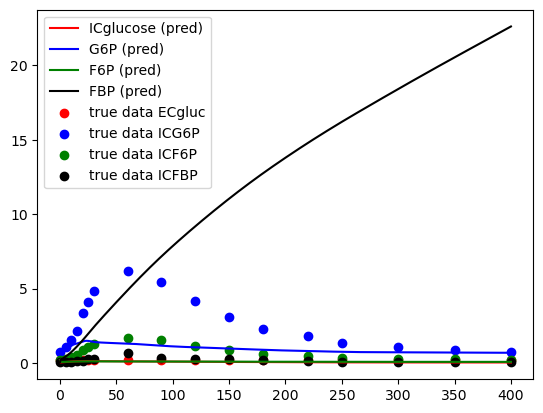

In [62]:
plt.plot(sol.ts,sol.ys[:,0],label="ICglucose (pred)",c="red")
plt.plot(sol.ts,sol.ys[:,1],label="G6P (pred)",c="blue")
plt.plot(sol.ts,sol.ys[:,2],label="F6P (pred)",c="green")
plt.plot(sol.ts,sol.ys[:,3],label="FBP (pred)",c="black")
# plt.plot(sol.ts,sol.ys[:,2],label="F6P (pred)",c="gree/n")
# plt.plot(sol.ts,sol.ys[:,2],label="G1P (pred)",c="green")
# plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.plot(new_ts,ECtreh_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
plt.scatter(time_points,glycolysis_data['ICglucose'],label="true data ECgluc",c="red")
plt.scatter(time_points,glycolysis_data['ICG6P'],label="true data ICG6P",c="blue")
plt.scatter(time_points,glycolysis_data['ICF6P'],label="true data ICF6P",c="green")
plt.scatter(time_points,glycolysis_data['ICFBP'],label="true data ICFBP",c="black")
# plt.scatter(time_points,glycolysis_data['G6P'],label="true data ICgluc")
plt.legend()
# plt.yscale("log")

In [44]:
# log_loss_func=jax.jit(create_log_params_log_loss_func(JaxKmodel))
from source.parameter_estimation.training import *


class NeuralODE():
    def __init__(self,func):

        self.func=func
        self.rtol=1e-3
        self.atol=1e-6
        self.max_steps=200000
        
    def __call__(self,ts,y0,params):
        solution = diffrax.diffeqsolve(
        diffrax.ODETerm(self.func),
        diffrax.Kvaerno5(),
        t0=ts[0],
        t1=ts[-1],
        dt0=ts[1] - ts[0],
        y0=y0,
        args=(params),
        stepsize_controller=diffrax.PIDController(rtol=self.rtol, atol=self.atol,pcoeff=0.4,icoeff=0.3,dcoeff=0),
        saveat=diffrax.SaveAt(ts=ts),
        max_steps=self.max_steps)

        return solution.ys


glycolyse=jax.jit(NeuralODE(glycolysis(interpolated_mets)))




In [46]:
def create_log_params_loss_func(model,to_include:list):
    """Loss function for log transformed parameters """
    def loss_func(params,ts,ys):
        params=exponentiate_parameters(params)
        mask=~jnp.isnan(jnp.array(ys))
        ys=jnp.atleast_2d(ys)
        y0=ys[0,:]
        y_pred=model(ts,y0,params)
        ys = jnp.where(mask, ys, 0)
        y_pred = jnp.where(mask, y_pred, 0)


        ys=ys[:,to_include]
        y_pred=y_pred[:,to_include]

        non_nan_count = jnp.sum(mask)
        
        loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count
        return loss
    return loss_func




log_loss_func=jax.jit(create_log_params_loss_func(glycolyse,[0,1,2]))
# loss_func=jax.jit(create_loss_func(glycolyse))


@jax.jit
def update_log(opt_state,params,ts,ys):
    """Update rule for the gradients for log-transformed parameters. Can only be applied
    to nonnegative parameters"""
    log_params=log_transform_parameters(params)
    loss=log_loss_func(log_params,ts,ys)
    grads=jax.jit(jax.grad(log_loss_func,0))(log_params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    #we perform updates in log space, but only return params in lin space
    log_params = optax.apply_updates(log_params, updates)
    lin_params = exponentiate_parameters(log_params) 
    return opt_state,lin_params,loss,grads

# loss_func(params,time_points,jnp.array(glycolysis_data[['ICglucose','ICG6P']]))



dataset=glycolysis_data[['ICglucose','ICG6P','ICF6P','ICFBP']]

dataset=jnp.array(dataset)

log_loss_func(params,time_points,dataset)

Array(8149.92969152, dtype=float64)

In [47]:
params_init=params
lr=1e-3
optimizer = optax.adabelief(lr)
clip_by_global=optax.clip_by_global_norm(np.log(4))
optimizer = optax.chain(optimizer,clip_by_global)
opt_state = optimizer.init(params_init)
opt_state,params_init,loss,grads=update_log(opt_state,params_init,time_points,
                                            jnp.array(glycolysis_data[['ICglucose','ICG6P','ICF6P','ICFBP']]))

In [68]:
params_init=params
lr=1e-3
optimizer = optax.adabelief(lr)
clip_by_global=optax.clip_by_global_norm(np.log(4))
optimizer = optax.chain(optimizer,clip_by_global)
opt_state = optimizer.init(params_init)


print("round 3")
# alpha1=np.linspace(0.2,1.0,2500)
for step in range(4000):
    opt_state,params_init,loss,grads=update_log(opt_state,params_init,time_points,
                                                jnp.array(glycolysis_data[['ICglucose','ICG6P','ICF6P','ICFBP']]))
    if step% 50==0:
        
#           # Scale step to range [0, 1]
#         # print(f"global norm: {global_norm(grads)}")
        print(f"Step {step}, Loss {loss}")





# for step in range(1000):
#     opt_state,params_init2,loss,grads=update_log(opt_state,params_init2,time_points[0:7],jnp.array(glycolysis_data['ICglucose'])[0:3])
#     print(loss)

round 3
Step 0, Loss 1.3766822201155973
Step 50, Loss 0.9465223732320055
Step 100, Loss 0.3269902618634062
Step 150, Loss 0.3107456507476883
Step 200, Loss 0.30280147291372345
Step 250, Loss 0.28599508386813205
Step 300, Loss 0.25802874125007663
Step 350, Loss 0.2533567912258408
Step 400, Loss 0.24917489160222583
Step 450, Loss 0.3154212493286388
Step 500, Loss 0.2805013188331182
Step 550, Loss 0.25906825808580713
Step 600, Loss 0.24436293230694345
Step 650, Loss 0.23607854322830626
Step 700, Loss 0.2301891202922619
Step 750, Loss 0.22415425045858992
Step 800, Loss 0.21742787983724868
Step 850, Loss 0.20992275564536025
Step 900, Loss 0.20161685428582493
Step 950, Loss 0.19257670509388236
Step 1000, Loss 0.18243705762382273
Step 1050, Loss 0.17097153038754642
Step 1100, Loss 0.15805213651496958
Step 1150, Loss 0.14346582285286066
Step 1200, Loss 0.12733752798731812
Step 1250, Loss 0.10989966240311703
Step 1300, Loss 0.0918469532500189
Step 1350, Loss 0.07409815680766232
Step 1400, Loss 

Text(0.5, 1.0, 'Glucose simulation')

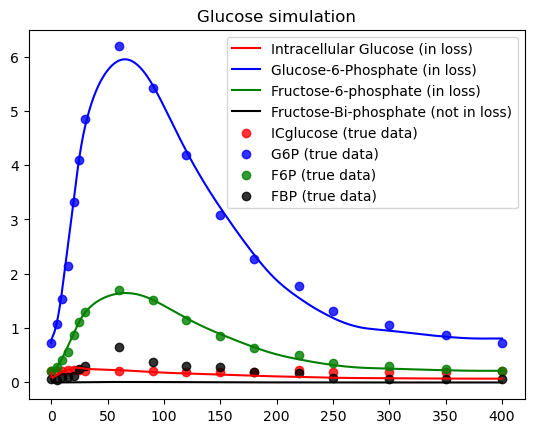

In [69]:
plt.plot(ts,glycolyse(ts,y0,params_init)[:,0],c="red",label="Intracellular Glucose (in loss)")
plt.plot(ts,glycolyse(ts,y0,params_init)[:,1],c="blue",label="Glucose-6-Phosphate (in loss)")
plt.plot(ts,glycolyse(ts,y0,params_init)[:,2],c="green",label="Fructose-6-phosphate (in loss)")
plt.plot(ts,glycolyse(ts,y0,params_init)[:,3],c="black",label="Fructose-Bi-phosphate (not in loss)")

plt.scatter(time_points,glycolysis_data['ICglucose'],label="ICglucose (true data)",c="red",alpha=0.8)
plt.scatter(time_points,glycolysis_data['ICG6P'],label="G6P (true data)",c="blue",alpha=0.8)
plt.scatter(time_points,glycolysis_data['ICF6P'],label="F6P (true data)",c="green",alpha=0.8)
plt.scatter(time_points,glycolysis_data['ICFBP'],label="FBP (true data)",c="black",alpha=0.8)
plt.legend()
plt.title("Glucose simulation")
# plt.yscale("log")

In [70]:
class glycolysis():
    def __init__(self,
                  interpolate_dict):
       self.interpolate_dict=interpolate_dict

    def __call__(self,t,y,args):
        
        params=args


        met_names=['ICglucose','ICG6P','ICF6P',"ICFBP"]
        y=dict(zip(met_names,y))


        y['ECglucose']=0.0943666793891201

        y['ICtreh']=self.interpolate_dict['ICtreh'].evaluate(t)
        # y['ICF6P']=self.interpolate_dict['ICF6P'].evaluate(t)
        # y['ICG1P']=self.interpolate_dict['ICG1P'].evaluate(t)
        y['ICG1P']=0.130
        y['ICATP']=4.52
        y['ICAMP']=0.31
        


        eval_dict={**y,**params}
        #modifiers and stuff
        # eval_dict['ICPHOS']

        rate_vGLT=v_GLT(eval_dict)
        rate_vHXK=v_HXK(eval_dict)
        rate_vNTH1=v_NTH1(eval_dict)
        rate_vPGI=v_PGI(eval_dict)

        rate_vsinkG6P=v_sinkG6P(eval_dict)
        rate_vsinkF6P=v_sinkF6P(eval_dict)
        rate_vPGM1=v_PGM1(eval_dict)
        rate_vTPS1=v_TPS1(eval_dict)
        rate_vPFK=v_PFK(eval_dict)
        rate_vsinkF16P=v_sinkF16P(eval_dict)

        dICglci=+rate_vGLT - rate_vHXK +2*rate_vNTH1
        dICG6P=+rate_vHXK-rate_vPGI -rate_vsinkG6P +rate_vPGM1-rate_vTPS1#we reverse the direction of the sink, since in logspace parameters cannot be negative
        dICF6P=+rate_vPGI +rate_vsinkF6P-rate_vPFK
        dICFBP=rate_vPFK -rate_vsinkF16P



        return jnp.stack([dICglci,dICG6P,dICF6P,dICFBP])


interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    'ICtreh':ECtreh_interpolation_cubic}



glycolyse=jax.jit(glycolysis(interpolated_mets))
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,400,1000)

solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

y0=jnp.array([0.2,0.716385,0.202293,0.057001])



sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.1, 
                          y0=y0,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=params,
                            max_steps=10000)


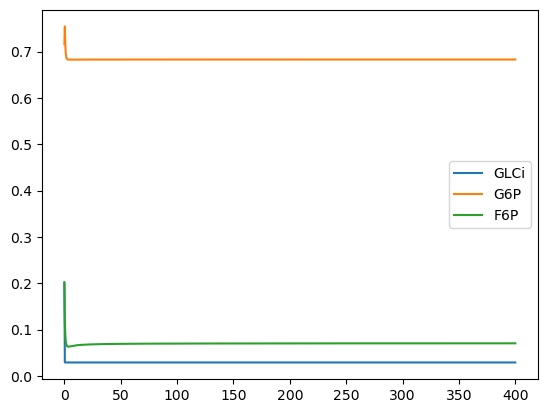

In [75]:


plt.plot(sol.ts,sol.ys[:,0],label="GLCi")
plt.plot(sol.ts,sol.ys[:,1],label="G6P")
plt.plot(sol.ts,sol.ys[:,2],label="F6P")
plt.legend()